In [ ]:
import requests

Define URL and Authorization Key for API Requests

In [ ]:
url = "https://api.wanikani.com/v2/subjects?types="
payload={}
headers = {
  'Authorization': 'Bearer ENTER_KEY_HERE'
}

Get and Format input kanji data

In [ ]:
req_type = 'kanji'
response = requests.request("GET", url+req_type, headers=headers, data=payload)
# print(response.status_code)
resp_j = response.json()

kanji_characters = []
rad_components = []

while not resp_j['pages']['next_url'] == None:
  kanji_data = resp_j['data']
  for kanji in kanji_data:
    kanji_characters.append(kanji['data']['slug'])
    rad_components.append(kanji['data']['component_subject_ids'])
  response = requests.request('GET', resp_j['pages']['next_url'], headers=headers, data=payload)
  resp_j = response.json()

Get and Format output radical data

In [ ]:
req_type = 'radical'
response = requests.request("GET", url+req_type, headers=headers, data=payload)
# print(response.status_code)
resp_j = response.json()

In [ ]:
rad_data = resp_j['data']

In [ ]:
rad_ids = []
rad_characters = []
for rad in rad_data:
  rad_ids.append(rad['id'])
  rad_characters.append((rad['data']['slug'], rad['data']['characters']))

# print(rad_ids[:10], rad_characters[:10])

Convert input data to image data

In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

In [ ]:
loc = '/content/drive/MyDrive/Colab Notebooks/Radical Recognition'
font = ImageFont.truetype(loc + '/Font/ipaexm.ttf', 100)

kanji_images = np.zeros((len(kanji_characters),100,100,1))
for i, kanji in enumerate(kanji_characters):
  img = Image.new('RGB', (100,100))
  d = ImageDraw.Draw(img)
  d.text((0,0), kanji, font=font)
  # img.save(loc + '/Image Data/kanji' + str(i) + '.png')

  as_arr = np.array(img)
  for j in range(len(as_arr)):
    for k in range(len(as_arr[j])):
      kanji_images[i,j,k,0] = as_arr[j,k,0]

Create training and testing sets

In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
all_y = np.array([[j in i for j in rad_ids] for i in rad_components])
all_y_counts = np.zeros(all_y.shape[1])
for i in range(len(all_y)):
  for j in range(len(all_y[i])):
    if all_y[i][j]:
      all_y_counts[j] += 1
min_count = 60
y_rad_ids = np.array(rad_ids)[all_y_counts > min_count]
y_rad_characters = np.array(rad_characters)[all_y_counts > min_count]

print(y_rad_ids, y_rad_characters)

[  1  16  17  22  23  43  63  75  86  90 103 117] [['ground' '一']
 ['mouth' '口']
 ['dirt' '土']
 ['sun' '日']
 ['tree' '木']
 ['moon' '月']
 ['fingers' '扌']
 ['leader' 'ｲ']
 ['thread' '糸']
 ['flowers' '艹']
 ['tsunami' '氵']
 ['say' '言']]


In [ ]:
X = []
X_rad_components = []
y = []
for i in range(len(rad_components)):
  exists = False
  j = 0
  while j < len(rad_components[i]):
    if rad_components[i][j] in y_rad_ids:
      exists = True
      j += 1
    else:
      del rad_components[i][j]
  if exists:
    X_rad_components.append(rad_components[i])
    X.append(kanji_images[i])
    add_y = []
    for j in y_rad_ids:
      add_y.append(j in rad_components[i])
    y.append(add_y)


X = np.array(X)
y = np.array(y)
# print(X.shape, y.shape)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=1)

Create multi-label classification model

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, Flatten

In [ ]:
model = Sequential()

model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=(100,100, 1)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(y.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Train model and save best

In [ ]:
mc = ModelCheckpoint(loc+'/best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(X_train, y_train, batch_size=64, epochs=20, validation_data=(X_test, y_test), callbacks=[es,mc])

Epoch 1/20
13/13 [==============================] - 11s 752ms/step - loss: 14.7901 - accuracy: 0.1514 - val_loss: 0.9049 - val_accuracy: 0.3488
Epoch 2/20
13/13 [==============================] - 10s 729ms/step - loss: 0.4065 - accuracy: 0.5110 - val_loss: 0.2367 - val_accuracy: 0.6047
Epoch 3/20
13/13 [==============================] - 10s 794ms/step - loss: 0.1960 - accuracy: 0.6378 - val_loss: 0.1814 - val_accuracy: 0.6977
Epoch 4/20
13/13 [==============================] - 9s 707ms/step - loss: 0.1110 - accuracy: 0.7684 - val_loss: 0.1547 - val_accuracy: 0.6860
Epoch 5/20
13/13 [==============================] - 11s 807ms/step - loss: 0.0570 - accuracy: 0.8680 - val_loss: 0.1544 - val_accuracy: 0.7558
Epoch 6/20
13/13 [==============================] - 10s 735ms/step - loss: 0.0263 - accuracy: 0.8875 - val_loss: 0.1723 - val_accuracy: 0.7791
Epoch 7/20
13/13 [==============================] - 10s 728ms/step - loss: 0.0104 - accuracy: 0.9082 - val_loss: 0.1968 - val_accuracy: 0.7791

END

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model

In [ ]:
loc = '/content/drive/MyDrive/Colab Notebooks/Radical Recognition'
best_model = load_model(loc+'/best_model.h5')

In [ ]:
random_test = 56

In [ ]:
test_image = X[random_test]
prediction = np.array([j for (j,k) in zip(y_rad_characters, [i >= 0.5 for i in best_model.predict(test_image.reshape((1, 100, 100, 1)))[0]]) if k])
actual = np.array([i for (i,j) in zip (y_rad_characters, y[random_test]) if j])

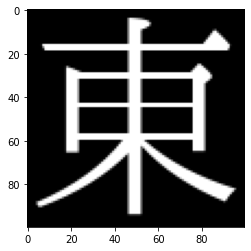

Predicted radical(s)
Actual radical(s)
	日 - sun
	木 - tree


In [ ]:
plt.imshow(test_image.reshape((100, 100)), cmap='gray')
plt.show()
print('Predicted radical(s)')
for i in prediction:
  print(f'\t{i[1]} - {i[0]}')
print('Actual radical(s)')
for i in actual:
    print(f'\t{i[1]} - {i[0]}')